In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import urllib.parse
import seaborn as sns
from tqdm import tqdm
import src.data.data_loader as data_loader

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [3]:
all_paths, paths_finished, paths_unfinished = data_loader.load_paths()
articles = data_loader.load_articles()
categories = data_loader.load_categories()
links = data_loader.load_links()
distance_matrix = data_loader.load_distance_matrix()


# Frustration

Our initial approach to measuring player frustration focuses on analyzing instances of backtracking. When players need to retrace their steps within a game, it often signals an increase in difficulty, which can be directly linked to frustration. Let's dive into it :

In [4]:
print(f"Across the study, we have {len(paths_finished)} finished paths, while {len(paths_unfinished)} remain unfinished, for a total of {len(all_paths)} paths.")


Across the study, we have 51318 finished paths, while 24875 remain unfinished, for a total of 76193 paths.


In [5]:
# Calculate the average number of backtracks for finished vs unfinished paths
avg_backtracks_finished = all_paths[all_paths['status'] == 'finished']['backtracks'].apply(len).mean()
avg_backtracks_unfinished = all_paths[all_paths['status'] != 'finished']['backtracks'].apply(len).mean()

# Output the results
print("\nAverage number of backtracks per game:")
print(f"Finished paths: {avg_backtracks_finished:.2f}")
print(f"Unfinished paths: {avg_backtracks_unfinished:.2f}")



Average number of backtracks per game:
Finished paths: 0.40
Unfinished paths: 0.52


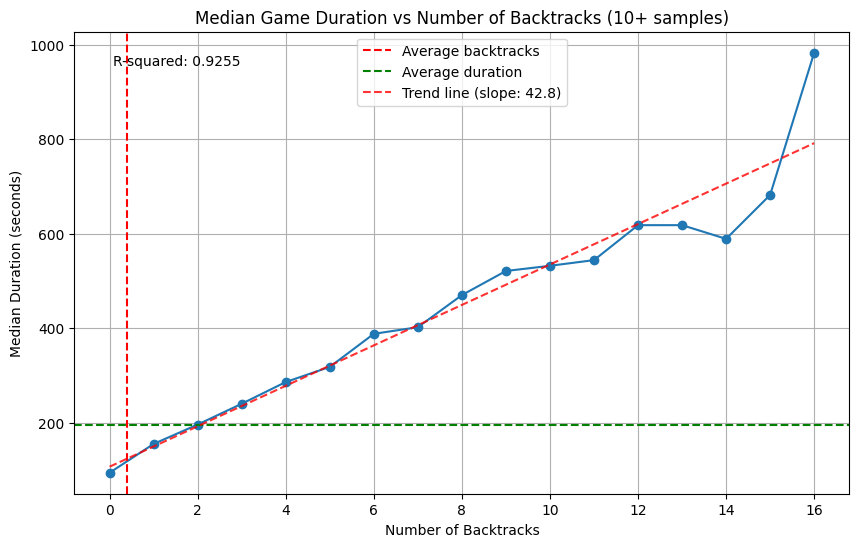

Counts of games with each number of backtracks:
backtracks
0     42323
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
dtype: int64

R-squared value: 0.9255


In [6]:
# Get finished games with and without backtracks

finished_with_bt = paths_finished[paths_finished['backtracks'].apply(len) > 0]
finished_no_bt = paths_finished[paths_finished['backtracks'].apply(len) == 0]

# Calculate average duration for each group
avg_duration_with_bt = finished_with_bt['durationInSec'].median()
avg_duration_no_bt = finished_no_bt['durationInSec'].median()

# Group finished games by number of backtracks and calculate median duration
backtrack_counts = paths_finished.groupby(paths_finished['backtracks'].apply(len)).size()
backtrack_durations = paths_finished.groupby(paths_finished['backtracks'].apply(len))['durationInSec'].median()

# Filter to keep only counts with at least 10 samples
filtered_counts = backtrack_counts[backtrack_counts >= 10]
filtered_durations = backtrack_durations[filtered_counts.index]

plt.figure(figsize=(10,6))
plt.plot(filtered_durations.index, filtered_durations.values, marker='o')
plt.axvline(x=avg_backtracks_finished, color='r', linestyle='--', label='Average backtracks')
plt.axhline(y=avg_duration_with_bt, color='g', linestyle='--', label='Average duration')
plt.xlabel('Number of Backtracks')
plt.ylabel('Median Duration (seconds)')
plt.title('Median Game Duration vs Number of Backtracks (10+ samples)')
plt.grid(True)

# Add a trend line
z = np.polyfit(filtered_durations.index, filtered_durations.values, 1)
p = np.poly1d(z)
plt.plot(filtered_durations.index, p(filtered_durations.index), "r--", alpha=0.8, 
         label=f'Trend line (slope: {z[0]:.1f})')

# Calculate R-squared
r_squared = r2_score(filtered_durations.values, p(filtered_durations.index))

plt.legend()
plt.text(0.05, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

print("Counts of games with each number of backtracks:")
print(filtered_counts)
print(f"\nR-squared value: {r_squared:.4f}")



In today’s fast-paced world, where content is rapidly consumed, players’ attention spans are increasingly shorter. If a game drags on too long, frustration can build as players wait longer for the rewarding sense of completion. As illustrated in the graph above, there is a noticeable correlation between the frequency of backtracking and overall game duration: each backtrack adds an average of 43 seconds to the game time.

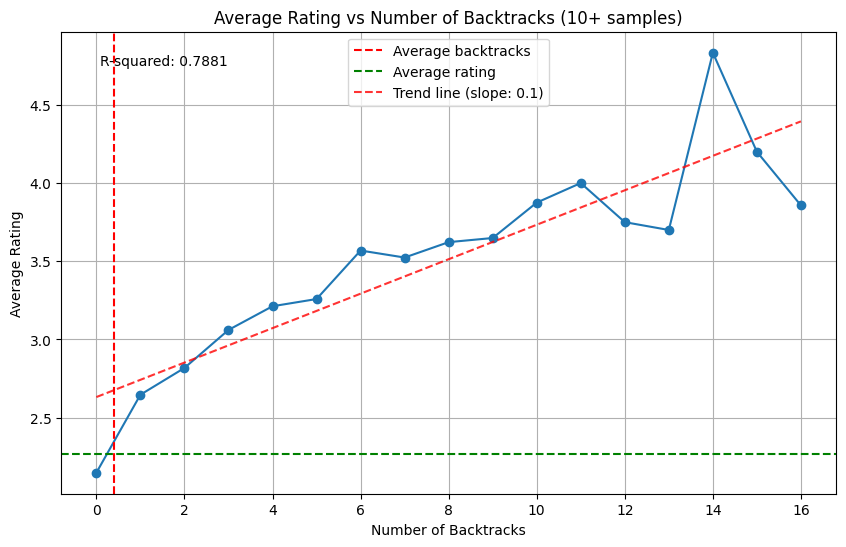

Counts of games with each number of backtracks:
backtracks
0     42323
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
dtype: int64

R-squared value: 0.7881


In [7]:
# Group finished games by number of backtracks and calculate median duration
backtrack_counts = paths_finished.groupby(paths_finished['backtracks'].apply(len)).size()
backtrack_ratings = paths_finished.groupby(paths_finished['backtracks'].apply(len))['rating'].mean()

# Filter to keep only counts with at least 10 samples
filtered_counts = backtrack_counts[backtrack_counts >= 10]
filtered_ratings = backtrack_ratings[filtered_counts.index]


plt.figure(figsize=(10,6))
plt.plot(filtered_ratings.index, filtered_ratings.values, marker='o')
plt.xlabel('Number of Backtracks')
plt.ylabel('Average Rating')
plt.axvline(x=avg_backtracks_finished, color='r', linestyle='--', label='Average backtracks')
plt.axhline(y=paths_finished['rating'].mean(), color='g', linestyle='--', label='Average rating')
plt.title('Average Rating vs Number of Backtracks (10+ samples)')
plt.grid(True)

z = np.polyfit(filtered_ratings.index, filtered_ratings.values, 1)
p = np.poly1d(z)

plt.plot(filtered_ratings.index, p(filtered_ratings.index), "r--", alpha=0.8, 
         label=f'Trend line (slope: {z[0]:.1f})')

r_squared = r2_score(filtered_ratings.values, p(filtered_ratings.index))

plt.legend()
plt.text(0.05, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

print("Counts of games with each number of backtracks:")
print(filtered_counts)
print(f"\nR-squared value: {r_squared:.4f}")

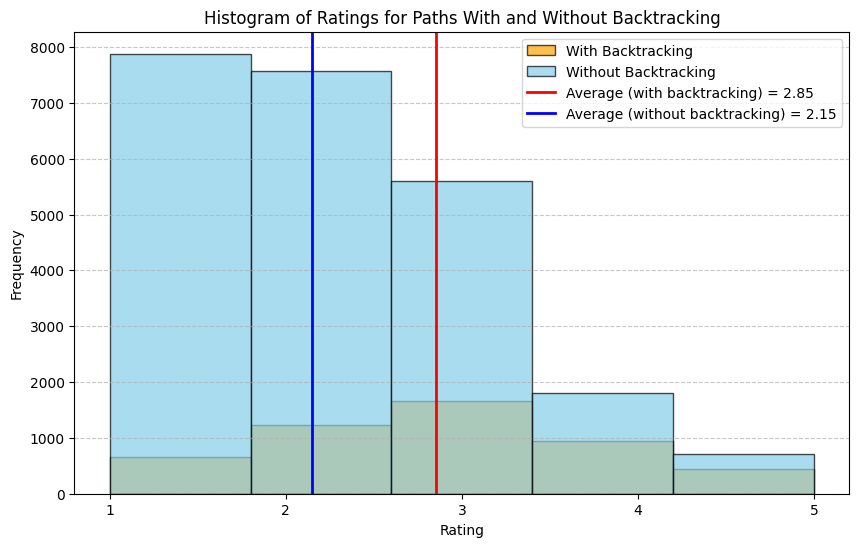

In [8]:
# Create mask for paths with backtracking and valid ratings
has_backtrack_mask = paths_finished['path'].str.contains('<')
has_rating_mask = paths_finished['rating'].notna()

# Filter ratings into two groups
ratings_with_backtrack = paths_finished.loc[has_backtrack_mask & has_rating_mask, 'rating']
ratings_without_backtrack = paths_finished.loc[~has_backtrack_mask & has_rating_mask, 'rating']

# Calculate averages using pandas methods
average_back = ratings_with_backtrack.mean()
average_no_back = ratings_without_backtrack.mean()


# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(ratings_with_backtrack, bins=5, color='orange', edgecolor='black', alpha=0.7, label='With Backtracking')
plt.hist(ratings_without_backtrack, bins=5, color='skyblue', edgecolor='black', alpha=0.7, label='Without Backtracking')

# Add vertical lines for the averages
plt.axvline(x=average_back, color='red', linestyle='-', linewidth=2, label=f'Average (with backtracking) = {average_back:.2f}')
plt.axvline(x=average_no_back, color='blue', linestyle='-', linewidth=2, label=f'Average (without backtracking) = {average_no_back:.2f}')

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1,6))
plt.title('Histogram of Ratings for Paths With and Without Backtracking')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


One other indicator of player frustration we consider is the game’s "difficulty rating" assigned by the player upon completion. Generally, as the difficulty of a game increases, so does the rating, offering a potential correlation with the level of frustration experienced. If the player needs to backtrack, the perceived difficulty of the game seems higher.

                                                    backtracks  traversed  \
Local community                                            2.0          3   
Soil profile                                              29.0         47   
Skåneland                                                  1.0          2   
Póvoa de Varzim                                            1.0          2   
Wikipedia Text of the GNU Free Documentation Li...        61.0        122   
La Grande Armée                                            2.0          4   
Konrad Lorenz                                              4.0          9   
Shackleton (crater)                                        5.0         12   
Cape Canaveral                                            26.0         63   
Lighting designer                                         17.0         44   
Lens (anatomy)                                            23.0         60   
Income disparity                                           4.0         11   

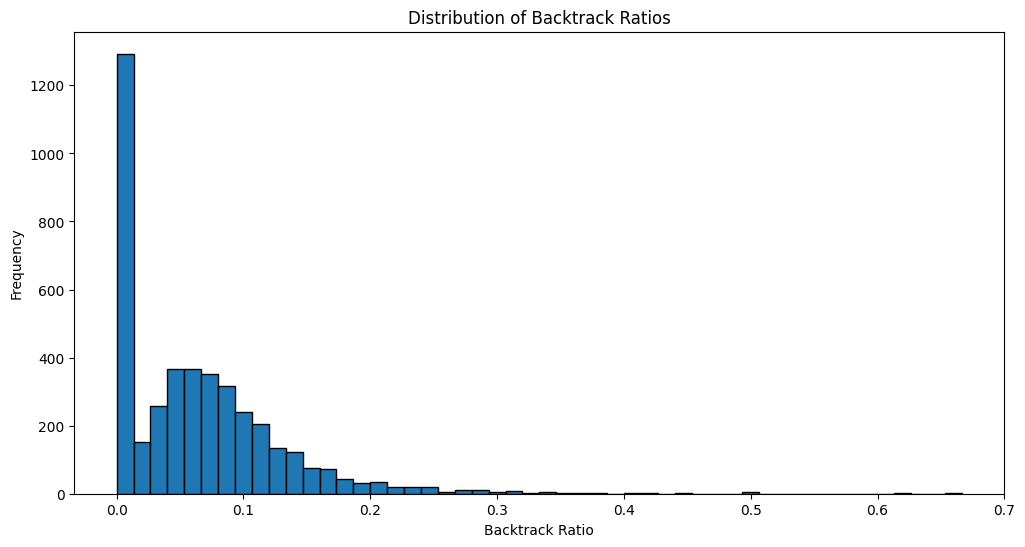

In [9]:

# Create a DataFrame with counts of backtracks and traversed
backtracks = pd.Series(all_paths['backtracks'].explode().dropna().tolist())
traversed = pd.Series(all_paths['traversed'].explode().dropna().tolist())

word_counts = pd.DataFrame({
    'backtracks': backtracks.value_counts(),
    'traversed': traversed.value_counts()
})

# Calculate the ratio of backtracks to traversed
word_counts['backtrack_ratio'] = word_counts['backtracks'] / word_counts['traversed']

# Fill NaN values with 0 (for words that were traversed but never backtracked)
word_counts['backtrack_ratio'] = word_counts['backtrack_ratio'].fillna(0)

# Sort by the ratio in descending order
word_counts_sorted = word_counts.sort_values('backtrack_ratio', ascending=False)

# Display the top 20 words with highest backtrack ratios for words with at least 100 occurrences
print(word_counts_sorted[word_counts_sorted['traversed'] >= 0].head(20))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(word_counts['backtrack_ratio'], bins=50, edgecolor='black')
plt.title('Distribution of Backtrack Ratios')
plt.xlabel('Backtrack Ratio')
plt.ylabel('Frequency')
plt.show()



In [10]:
# Count the number of games in each 'type' group
game_counts_by_type = paths_unfinished.groupby('type').size()

print(game_counts_by_type)


type
restart    15552
timeout     9323
dtype: int64


In conclusion, it’s evident that the game induces a certain level of frustration for players, with our backtracking analysis supporting this observation. The next step is to delve into understanding the causes of this frustration, particularly identifying what aspects of the game design lead to the need for backtracking.

---

# Explanation

In [11]:
# Create DataFrame of backtrack-target pairs
backtrack_df = pd.DataFrame([
    {'backtrack': backtrack, 'target': row['target']}
    for _, row in all_paths[all_paths['backtracks'].apply(len) > 0][['backtracks','target']].iterrows()
    for backtrack in row['backtracks']
])

print("\nArticle of backtrack vs target")
print(backtrack_df.value_counts().head(20))



Article of backtrack vs target
backtrack         target     
Soybean           Bean           111
Herbivore         Zebra           89
Protein           Bean            62
Cell (biology)    Telephone       46
Sport             Tiger Woods     42
Salsa music       Bean            42
Coffee            Bean            38
Optical fiber     Telephone       37
Animal            Zebra           34
Mexico            Bean            34
Sound             Telephone       31
Internet          Telephone       30
Plant             Bean            30
Eye               Telephone       30
Computer science  Telephone       28
Food              Bean            27
Agriculture       Bean            26
Africa            Zebra           26
Jupiter           Viking          24
South Africa      Zebra           24
Name: count, dtype: int64


We’ve observed that numerous backtracks stem from confusion over closely related words or concepts. Could this reveal gaps or missing connections within the game’s design that prevent players from progressing/finishing?

In [12]:
# Find missing targets 
articles_set = set(articles['article'])
missing_targets = set([target for target in paths_unfinished['target'] if target not in articles_set])

if missing_targets:
    print("Missing targets:")
    for target in missing_targets:
        print(target)
else:
    print("No missing targets found.")


Missing targets:
Great
The
Adolph Hitler
Test
Rat
Georgia
Fats
Netbook
Black ops 2
Kashmir
The Rock
Western Australia
 Zebra
Macedonia
Sportacus
Long peper
English
Bogota
Usa
Rss
Podcast
Christmas
Mustard
Charlottes web


Indeed, there are missing connections—and, even more frustratingly, some destinations are entirely unreachable. Imagine the player’s frustration in searching for “Christmas,” only to complete the game on “Santa Claus” and realize there’s no link back to “Christmas.” This lack of connection not only disrupts gameplay but can also leave players feeling stuck and unsatisfied, amplifying their frustration.

---

# Solution

To assess if a link is needed between two articles and measure their "distance," we can use:

- **Shortest Path**: Count the hops between articles in the dataset. A high hop count suggests a possible need for a direct link.
- **Cosine Similarity**: Calculate similarity between article embeddings. High similarity without a link may indicate a need for connection.
The heatmap below shows the differences between these two methods : 

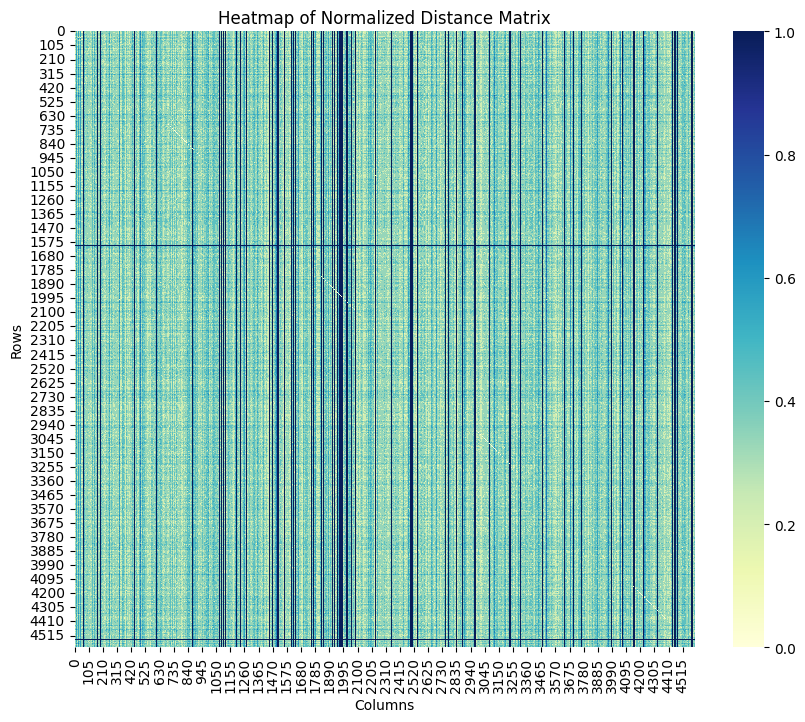

In [13]:
# Replace -1 values with np.nan to ignore them during normalization
distance_matrix_normalized = np.where(distance_matrix == -1, np.nan, distance_matrix)

# Perform normalization on the matrix, excluding NaN values
min_value = np.nanmin(distance_matrix_normalized)
max_value = np.nanmax(distance_matrix_normalized)
distance_matrix_normalized = (distance_matrix_normalized - min_value) / (max_value - min_value)

# Replace NaNs (original -1 values) with 1
distance_matrix_normalized = np.where(np.isnan(distance_matrix_normalized), 1, distance_matrix_normalized)

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix_normalized, cmap="YlGnBu", annot=False, cbar=True)
plt.title('Heatmap of Normalized Distance Matrix')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()


 ### Choice of similarity model

Let's look at that game, it will also enable us to select which model we want to use for the rest of the analysis to compute the similarity between 2 articles :

/Users/hugo/miniconda3/envs/ada/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


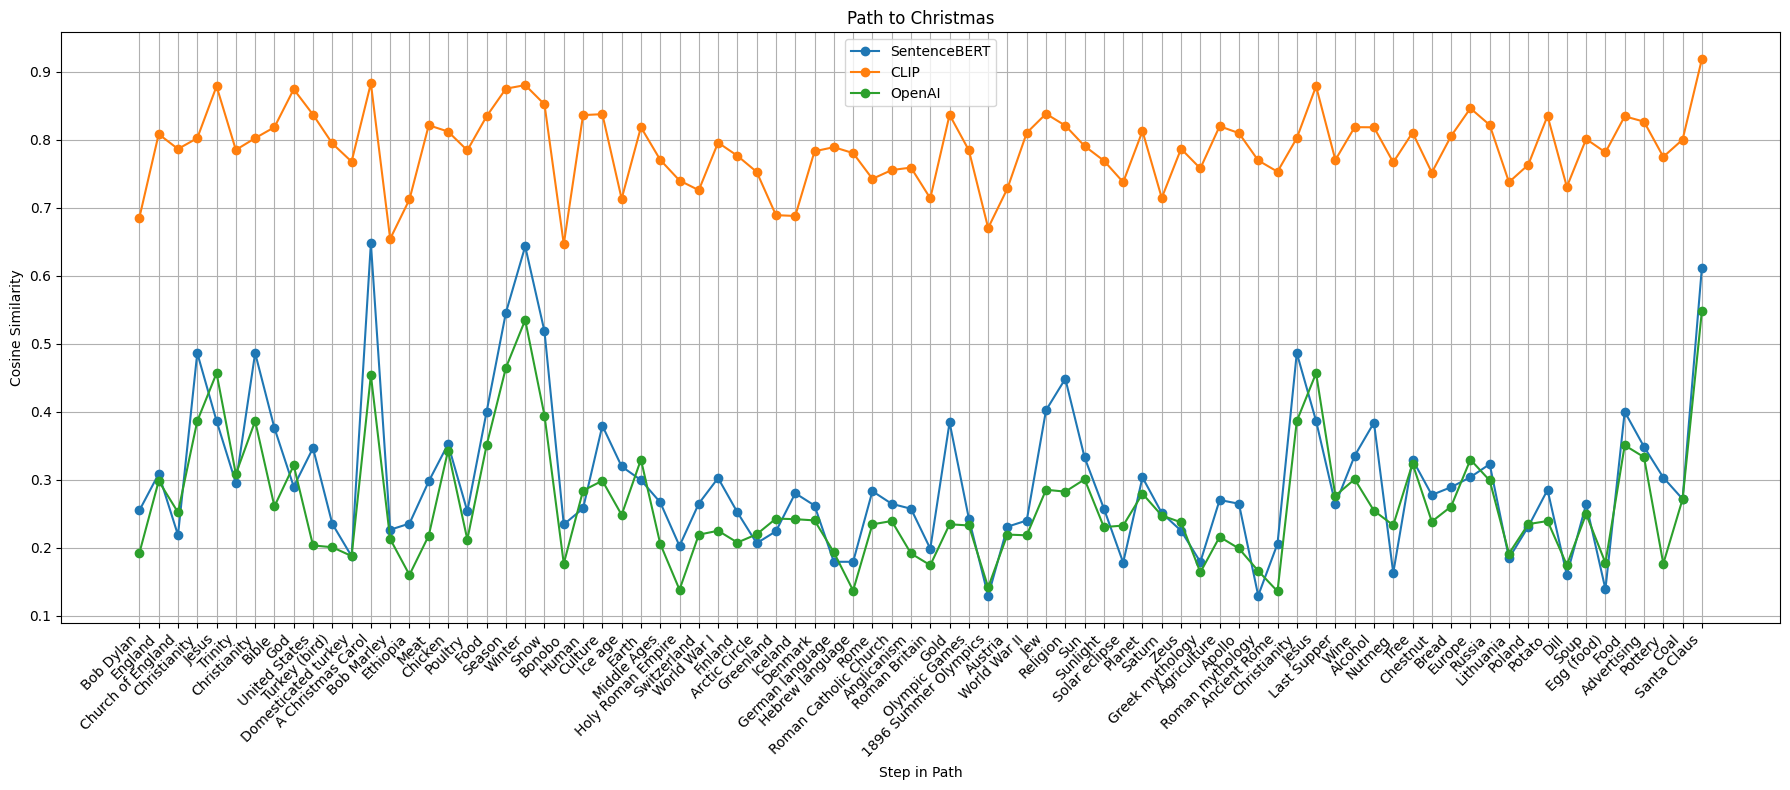

In [14]:
import torch
from sentence_transformers import SentenceTransformer, util
from src.utils.similarity import get_cosine_similarity_for_path_word_by_word, get_cosine_similarity_for_path_word_by_word_openai
from src.utils.utils import path_to_list

sb_model = SentenceTransformer("all-MiniLM-L6-v2", device="mps" if torch.backends.mps.is_available() else "cpu")
clip_model = SentenceTransformer("clip-ViT-B-32", device="mps" if torch.backends.mps.is_available() else "cpu")

christmas_path="Bob_Dylan;England;Church_of_England;Christianity;Jesus;Trinity;Christianity;Bible;God;United_States;Turkey_%28bird%29;Domesticated_turkey;A_Christmas_Carol;Bob_Marley;Ethiopia;Meat;Chicken;Poultry;Food;Season;Winter;Snow;Bonobo;Human;Culture;Ice_age;Earth;Middle_Ages;Holy_Roman_Empire;Switzerland;World_War_I;Finland;Arctic_Circle;Greenland;Iceland;Denmark;German_language;Hebrew_language;Rome;Roman_Catholic_Church;Anglicanism;Roman_Britain;Gold;Olympic_Games;1896_Summer_Olympics;Austria;World_War_II;Jew;Religion;Sun;Sunlight;<;Solar_eclipse;Planet;Saturn;Zeus;Greek_mythology;Agriculture;<;Apollo;Roman_mythology;Ancient_Rome;Christianity;Jesus;Last_Supper;Wine;Alcohol;<;Nutmeg;Tree;Chestnut;Bread;Europe;Russia;Lithuania;Poland;Potato;Dill;Soup;Egg_%28food%29;Food;Advertising;<;Pottery;Coal;Santa_Claus"
christmas_path = path_to_list(christmas_path)
bert_similarities = get_cosine_similarity_for_path_word_by_word(christmas_path, "Christmas", sb_model)
clip_similarities = get_cosine_similarity_for_path_word_by_word(christmas_path, "Christmas", clip_model)
openai_similarities = get_cosine_similarity_for_path_word_by_word_openai(christmas_path, "Christmas")


plt.figure(figsize=(18, 8))
plt.plot(range(len(christmas_path)), bert_similarities, marker='o', label='SentenceBERT')
plt.plot(range(len(christmas_path)), clip_similarities, marker='o', label='CLIP')
plt.plot(range(len(christmas_path)), openai_similarities, marker='o', label='OpenAI')
plt.title('Path to Christmas')
plt.xlabel('Step in Path') 
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.legend()

plt.xticks(range(len(christmas_path)), christmas_path, rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define a function to evaluate similarity trends
def evaluate_similarity(similarities, path, target):
    # Identify indices where the path matches the target concept
    target_indices = [i for i, step in enumerate(path) if target.lower() in step.lower()]
    max_similarity = np.max(similarities)
    avg_similarity = np.mean(similarities)
    mse = mean_squared_error([max_similarity] * len(similarities), similarities)  # How consistent is the trend?
    return {
        "max_similarity": max_similarity,
        "avg_similarity": avg_similarity,
        "mse": mse,
        "target_indices": target_indices,
    }

# Evaluate all models
target = "Christmas"
sb_metrics = evaluate_similarity(bert_similarities, christmas_path, target)
clip_metrics = evaluate_similarity(clip_similarities, christmas_path, target)
openai_metrics = evaluate_similarity(openai_similarities, christmas_path, target)

# Print results
print("SentenceBERT Metrics:", sb_metrics)
print("CLIP Metrics:", clip_metrics)
print("OpenAI Metrics:", openai_metrics)



SentenceBERT Metrics: {'max_similarity': np.float64(0.6476807594299316), 'avg_similarity': np.float64(0.29899517265034886), 'mse': np.float64(0.13349142072598713), 'target_indices': [12]}
CLIP Metrics: {'max_similarity': np.float64(0.9184123873710632), 'avg_similarity': np.float64(0.787330505324573), 'mse': np.float64(0.02011459619699941), 'target_indices': [12]}
OpenAI Metrics: {'max_similarity': np.float64(0.5479663259905397), 'avg_similarity': np.float64(0.2630375129840482), 'mse': np.float64(0.08882119381541513), 'target_indices': [12]}


As we calculate the similarities with our three language models with a path to « Christmas », we can see CLIP has a mean similarity much higher than OpenAI and BERT, leading to more coherent results for OpenAI and BERT. This might suggest overgeneralization, where CLIP finds connections between "Christmas" and unrelated or less relevant concepts along the path. OpenAI and BERT produce more nuanced results. This means they assign higher similarity scores to steps more semantically relevant to "Christmas" (like "Santa Claus" or "A Christmas Carol") and lower scores to unrelated concepts. Both could be two good model choices, but since we have to choose one, we decided to deepen our analysis. As we compared OpenAI and BERT, we searched for two examples that could help us choose one: two paths, one for Charles Darwin and the other for George Washington. We compared their similarities with different centuries and see if one model has a better similarity for the century corresponding to our target. For Charles Darwin, OpenAI has a better similarity for the 19th century than SentenceBERT. For George Washington, SentenceBERT has a higher similarity for the 20th century than the 18th century. In contrast, OpenAI has its highest similarity for the 18th century corresponding to G.W. We then choose OpenAI because it has the best results for those examples and it’s trained with much larger data than SentenceBERT.

### First test of threshold to find missing links : Fixed threshold on the similarity

In [16]:
from src.utils.similarity import should_have_link

#using arbitrary threshold
print(should_have_link("Santa Claus","Christmas"))
print(should_have_link("Santa Claus","Summer"))
print(should_have_link("Soybean","Bean"))


(True, 0.5479663259905397)
(False, 0.21323512811689968)
(True, 0.4775772786481707)


In [17]:
# Find potential missing links between articles based on semantic similarity
should_link_dict = {}
missing_link_pairs = []

# Iterate through all articles
for source_article in tqdm(articles['article'][:100]):#only 100 articles to limit runtime
    # Get existing links from current article
    existing_links = links[links['linkSource'] == source_article]
    full_source_article = open(f"data/plaintext_articles/{urllib.parse.quote(source_article.replace(' ', '_'))}.txt","r").read()
    source_article_lowered = full_source_article.lower()

    # Find articles that aren't currently linked from source article
    potential_targets = articles[~articles['article'].isin(existing_links['linkTarget'])]
    potential_targets = potential_targets[potential_targets['article'].str.lower().apply(lambda x: x in source_article_lowered)]
    potential_targets = potential_targets[potential_targets['article'].apply(lambda x: should_have_link(source_article,x)[0])]
    potential_targets = potential_targets[potential_targets['article'] != source_article]
    
    
    if len(potential_targets) > 0:
        should_link_dict[source_article]= potential_targets['article'].tolist()
        for target in potential_targets['article']:
            missing_link_pairs.append({
                'source': source_article,
                'target': target
            })


for article,targets in should_link_dict.items():
    print(f"{article}: {targets}")

pd.DataFrame(missing_link_pairs).to_csv('data/missing_links.csv', index=False)

100%|██████████| 100/100 [00:09<00:00, 10.56it/s]

Édouard Manet: ['Paul Cézanne']
Óengus I of the Picts: ['Picts']
€2 commemorative coins: ['Euro']
11th century: ['Middle Ages']
12th century: ['Middle Ages']
13th century: ['4th century', 'Crusades', 'Middle Ages']
14th century: ['4th century', '5th century']
19th century: ['Industrial Revolution']
1 Ceres: ['Ceres (dwarf planet)']
2004 Atlantic hurricane season: ['Hurricane Dennis']
21st century: ['1st century', '2nd century']
4 Vesta: ['Asteroid']
4th century: ['Constantine I']
90377 Sedna: ['Scattered disc']
AC DC: ['Alternating current']
AK-47: ['Firearm', 'Weapon']
ASCII: ['Algorithm', 'Alphabet', 'BASIC', 'Unix']
Aachen: ['Austria']
Aardvark: ['Ape']
Abacá: ['Manila']
Abacus: ['Algorithm']
Abbey Theatre: ['Abbey']
Abbot: ['Archbishop of Canterbury', 'Pope']
Abidjan: ['Ghana', 'Ivory']
Abkhazia: ['Armenia']
Absinthe: ['Alcohol', 'Wine']


In this initial iteration, the model appears to perform well, allowing us to easily add additional links. It identifies article titles mentioned within the text that are not yet linked, even when they are semantically close. 

---

# Is there a better way to do it ?

Let’s analyze the similarities across the entire game by calculating the similarity between each page and the target article.

In [18]:

all_path_similarities_unfinished, all_path_similarities_finished = data_loader.load_all_path_similarities()

In [19]:
# Take only the last 10 elements of each path
from src.utils.utils import shorten_list_finished, shorten_list_unfinished

all_path_similarities_unfinished_copy = all_path_similarities_unfinished.copy()
all_path_similarities_unfinished_copy['similarities'],all_path_similarities_unfinished_copy['path'] = zip(*all_path_similarities_unfinished_copy.apply(shorten_list_unfinished, axis=1))

similarities_unfinished = all_path_similarities_unfinished_copy[all_path_similarities_unfinished_copy['similarities'].apply(lambda x: len(x) > 0)][['similarities','path','target']]


all_path_similarities_finished_copy = all_path_similarities_finished.copy()
all_path_similarities_finished_copy['similarities'],all_path_similarities_finished_copy['path'] = zip(*all_path_similarities_finished_copy.apply(shorten_list_finished, axis=1))
similarities_finished = all_path_similarities_finished_copy['similarities']

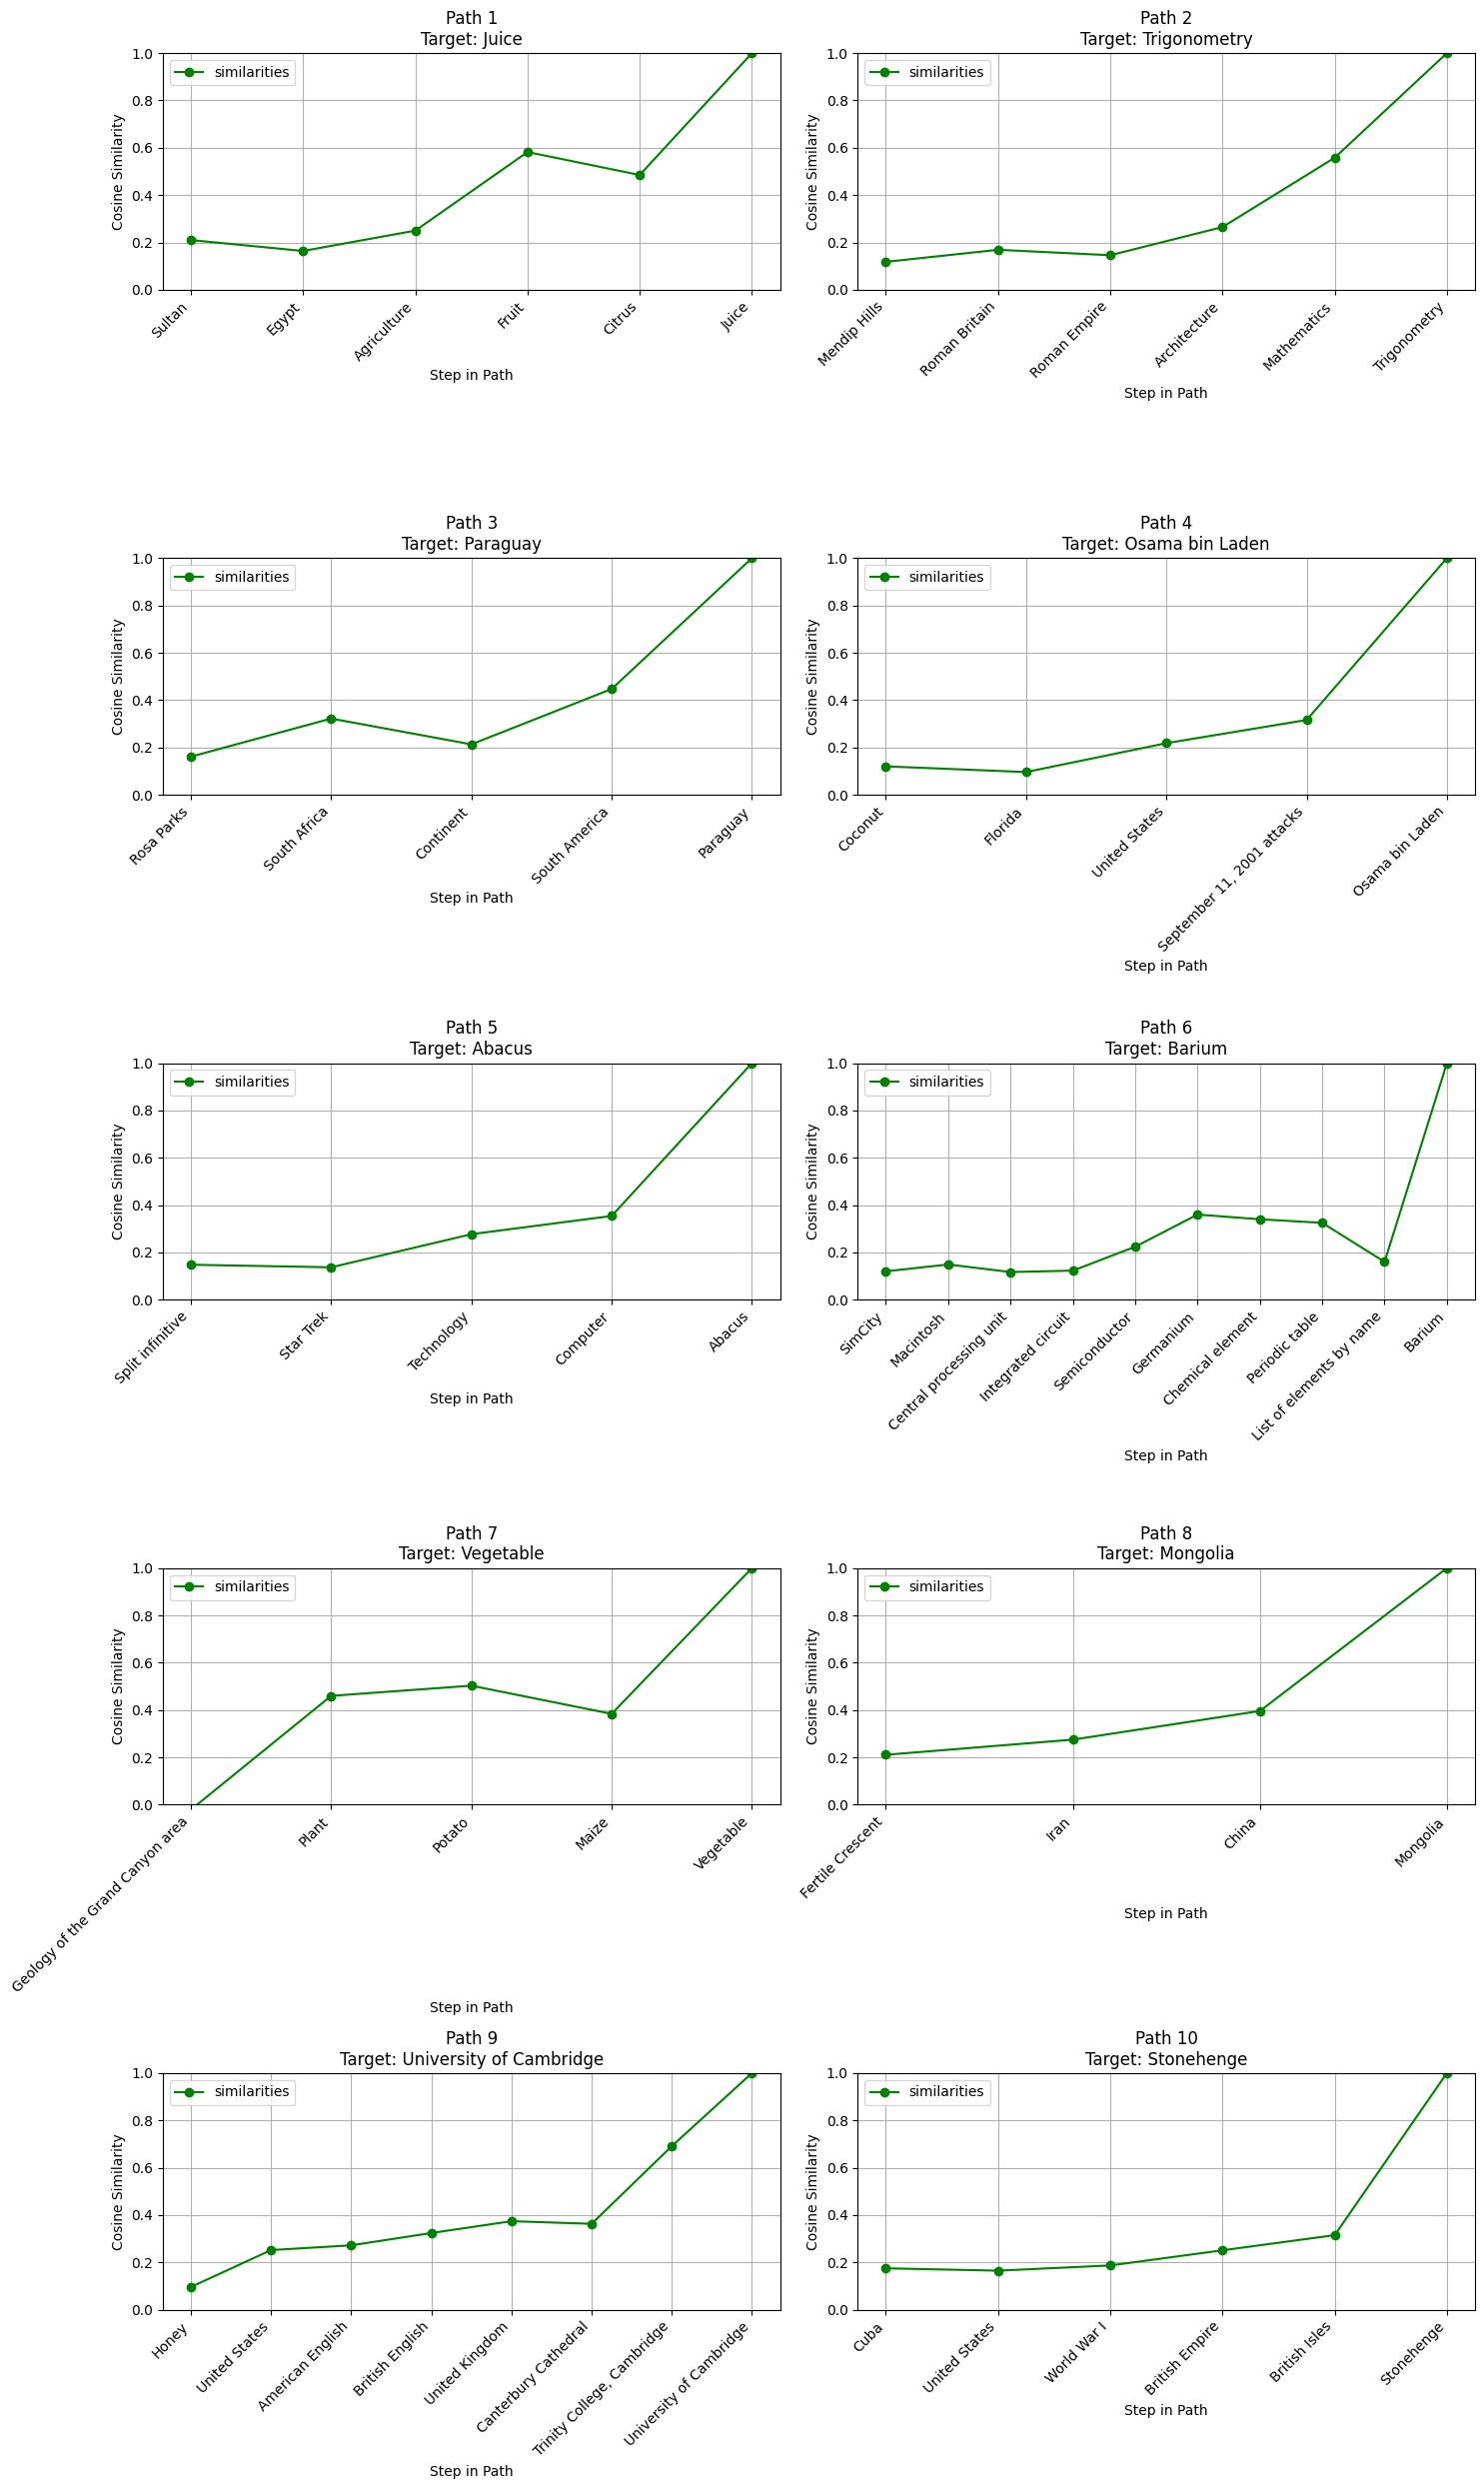

In [20]:

# Create a figure with subplots for the first 10 paths
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.flatten()

# Colors for each model
colors = {
    'similarities': 'green'
}

selected_finished = all_path_similarities_finished_copy.sample(10)
# Plot first 10 paths
for i in range(10):
    path = selected_finished.apply(lambda x: x['path'],axis=1).iloc[i]
    target = selected_finished['target'].iloc[i]
    
    # Plot each model's similarities
    for model in ['similarities']:
        similarities = selected_finished.apply(lambda x: x[model],axis=1).iloc[i]
        axes[i].plot(range(len(similarities)), similarities, 
                    marker='o', label=model, color=colors[model])
    
    # Customize the plot
    axes[i].set_title(f'Path {i+1}\nTarget: {target}')
    axes[i].set_xlabel('Step in Path')
    axes[i].set_ylabel('Cosine Similarity')
    axes[i].set_ylim(0, 1)
    axes[i].grid(True)
    axes[i].legend()
    
    # Add path words as x-tick labels
    axes[i].set_xticks(range(len(path)))
    axes[i].set_xticklabels(path, rotation=45, ha='right')

plt.tight_layout()
plt.show()


Mhhhhh, it seems like there is a trend over there !!

# Plot similarity evolution for 100 paths together

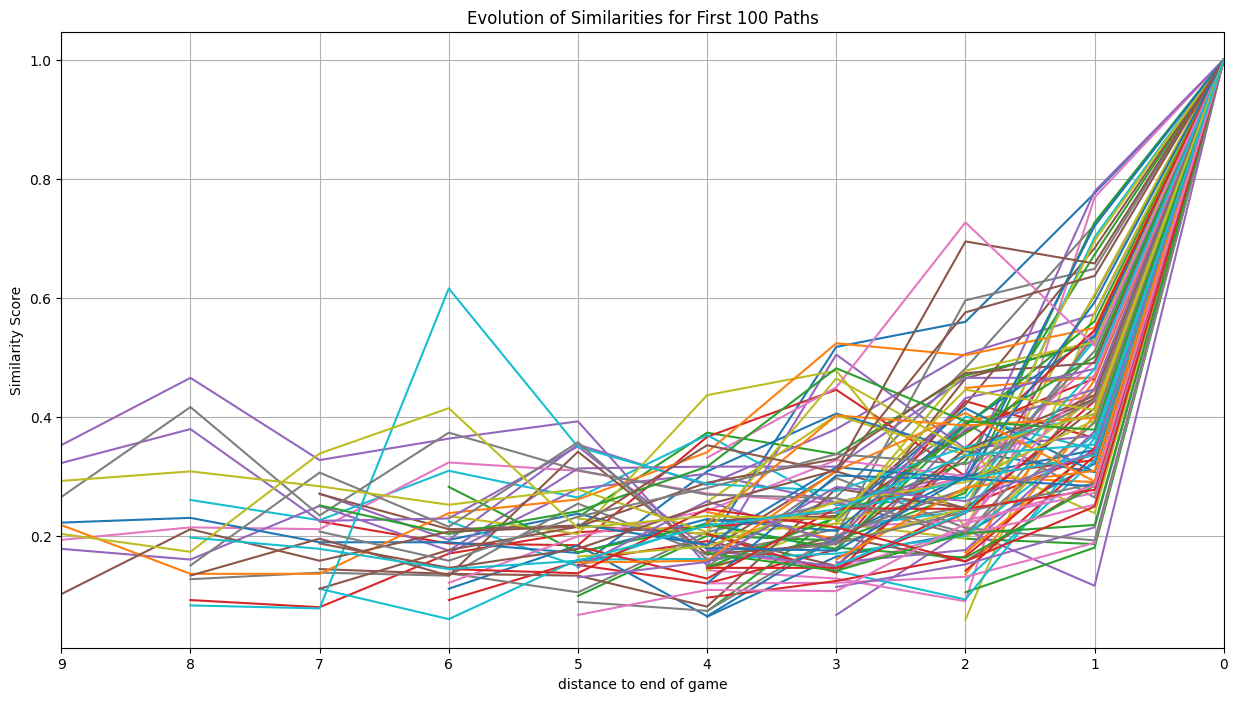

In [21]:

plt.figure(figsize=(15, 8))

# Plot first 100 similarity evolutions
random_finished = all_path_similarities_finished_copy.sample(100)
for index, path in random_finished.iterrows():
    similarities = path['similarities']
    reversed_similarities = similarities[::-1]
    plt.plot(reversed_similarities)


plt.xlabel('distance to end of game')
plt.ylabel('Similarity Score') 
plt.xlim(9,0)
plt.title('Evolution of Similarities for First 100 Paths')

# Add grid for better readability
plt.grid(True)

plt.show()


Across all completed games, we observe a clear trend in the endgame stage. Let’s examine whether this trend extends to unfinished games as well (excluding the final step, of course).

In [22]:
from src.utils.similarity import process_similarities

similarities_by_distance_finished = process_similarities(similarities_finished)
similarities_by_distance_unfinished = process_similarities(similarities_unfinished['similarities'])

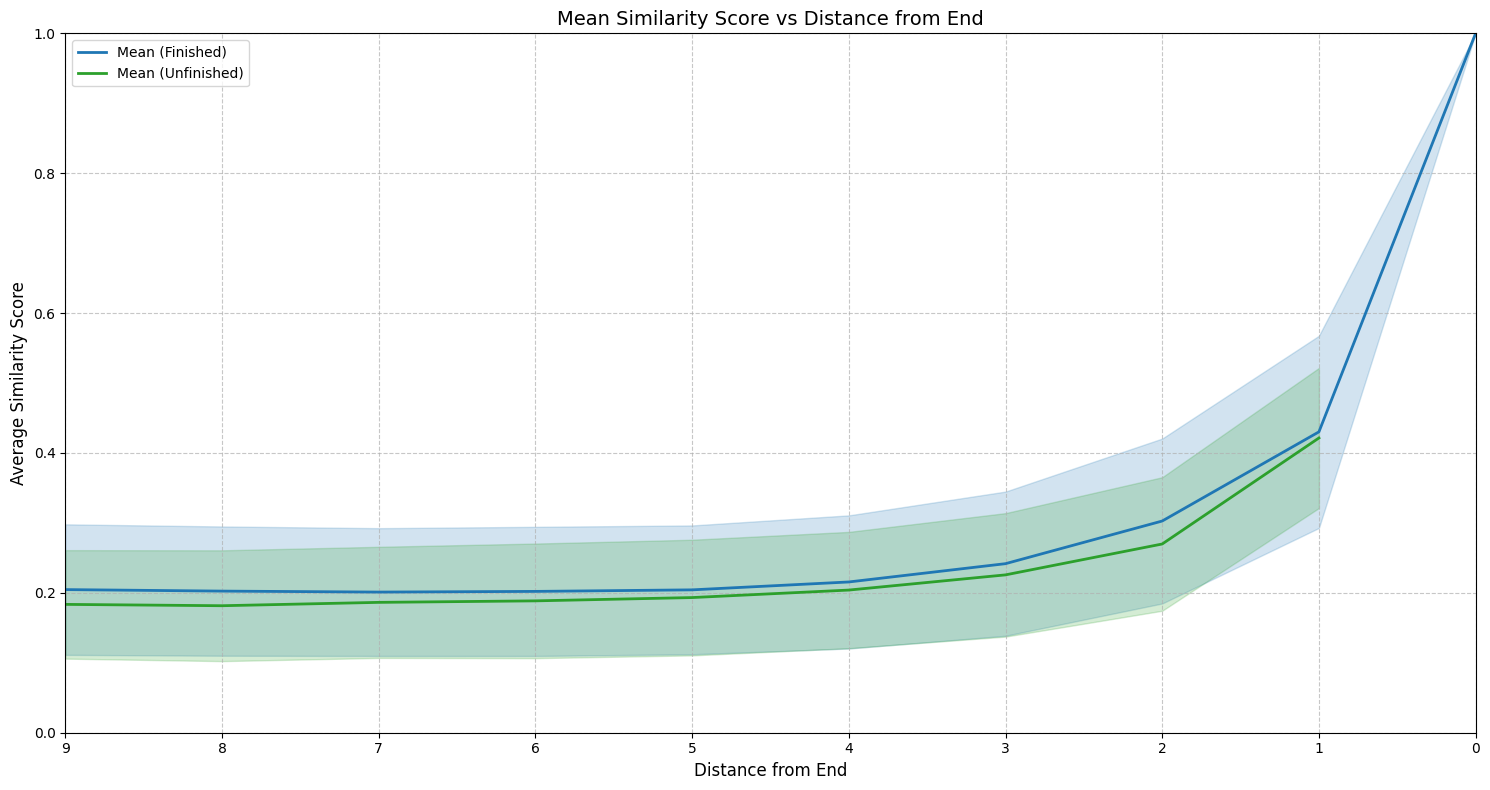

In [23]:
# Calculate means, medians, and standard deviations
stats = {
    'Finished': [similarities_by_distance_finished, range(10)],
    'Unfinished': [similarities_by_distance_unfinished, range(1,10)]
}

plt.figure(figsize=(15, 8))
colors = ['#1f77b4', '#2ca02c']

for i, (path_type, (similarities, x)) in enumerate(stats.items()):
    means = [np.mean(sublist) for sublist in similarities]
    stds = [np.std(sublist) for sublist in similarities]
    
    plt.plot(x, means, color=colors[i], label=f'Mean ({path_type})', linewidth=2)
    plt.fill_between(x, [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     color=colors[i], alpha=0.2)

plt.xlabel('Distance from End', fontsize=12)
plt.ylabel('Average Similarity Score', fontsize=12)
plt.ylim(0,1)
plt.xlim(9,0)
plt.title('Mean Similarity Score vs Distance from End', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


Our analysis confirms a trend in the endgame stage, even within unfinished paths. To investigate this, we focused on the highest similarity point within each game and the last eight moves leading up to it. This trend reveals several possible scenarios:

- **Player Confusion**: Some players appear to struggle, failing to reach a similarity threshold of 0.3. In such cases, the game might be disregarded by the search algorithm, as the low similarity indicates a lack of meaningful progression.

- **Missed Links**: Players may overlook critical links if they appear later in the article rather than at the beginning. This suggests a potential improvement area in link placement to aid player navigation. (Refer to the accompanying graph for a visual representation.)

- **Missing Final Link**: In some cases, there may be a missing link between the last article the player reached and the target, creating a gap in progression and heightening player frustration.

In [24]:
from src.utils.utils import get_missing_links

unfinished_missing_links = similarities_unfinished.apply(get_missing_links,axis=1)
print("Most common pairs of articles that may be missing links:")
print(unfinished_missing_links.value_counts().head(20))


Most common pairs of articles that may be missing links:
biggest_similarity_article  target              
Soybean                     Bean                    210
Internet                    Telephone               125
Africa                      Zebra                    78
Animal                      Zebra                    73
India                       Economy of India         71
Shark                       Nurse sharks             53
Food                        Bean                     49
Giraffe                     Zebra                    49
Norse mythology             Viking                   40
Plant                       Bean                     39
Technology                  Telephone                39
Human                       Telephone                38
Batman                      Penguin                  33
Cat                         Computer                 33
Coffee                      Bean                     32
Canadian Senate             Senate of Canada         3

In [25]:
# Filter pairs that appear at least 2 times
frequent_pairs = unfinished_missing_links.value_counts()[unfinished_missing_links.value_counts() >= 2]
link_missed_by_player = []
link_absent = []

for source, target in frequent_pairs.index:
    full_source_article = open(f"data/plaintext_articles/{urllib.parse.quote(source.replace(' ', '_'))}.txt","r").read()
    source_article_lowered = full_source_article.lower()
    if links[(links['linkSource'] == source) & (links['linkTarget'] == target)].shape[0] > 0:
        link_missed_by_player.append((source,target))
    elif target.lower() in source_article_lowered:
        link_absent.append((source,target))


print(f"Link missed by player: {len(link_missed_by_player)}")
print(f"Link absent: {len(link_absent)}")

# Save missing links to CSV
missing_links_df = pd.DataFrame(link_absent, columns=['source', 'target'])
missing_links_df.to_csv('data/missing_links.csv', index=False)

# Save links missed by players to CSV 
missed_by_player_df = pd.DataFrame(link_missed_by_player, columns=['source', 'target'])
missed_by_player_df.to_csv('data/links_missed_by_player.csv', index=False)





Link missed by player: 96
Link absent: 217


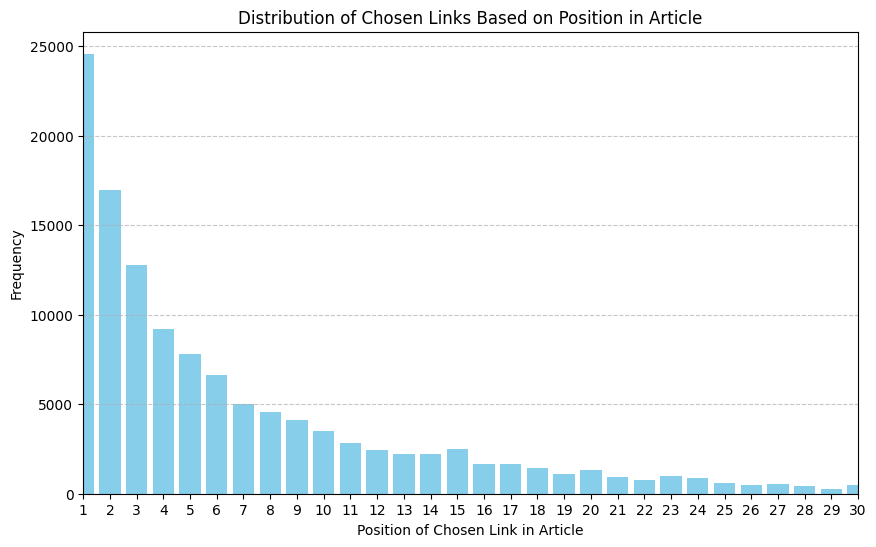

In [26]:
chosen_links_df =pd.read_csv('data/chosen_links_rank.csv')


rank_data = chosen_links_df['RankChosen'].dropna()

# Count the frequency of each rank
rank_counts = rank_data.value_counts()

plt.figure(figsize=(10, 6))
plt.bar(rank_counts.index, rank_counts.values, color='skyblue')
plt.xlabel('Position of Chosen Link in Article')
plt.xlim(1, 30)  # Limit to first 20 positions
plt.ylabel('Frequency')
plt.title('Distribution of Chosen Links Based on Position in Article')

# Set x-ticks to show every position within the limited range
plt.xticks(range(1, 31))  

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


---

# Find missing link with our new method

In [27]:
from sklearn.manifold import TSNE

In [28]:
all_words_df = pd.read_csv('data/all_words_df.csv')
all_words_df['embedding'] = all_words_df['embedding'].apply(
    lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x)
)

# Filter out rows where 'encoded_version' is still invalid (e.g., not arrays)
all_words_df = all_words_df.dropna(subset=['embedding'])


embeddings = np.vstack(all_words_df['embedding'].values)
tsne = TSNE(n_components=2, random_state=42)
tsne3D = TSNE(n_components=3, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)
reduced_embeddings3D = tsne3D.fit_transform(embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
# Load isolated in/out words from files
with open('largest_component.txt', 'r') as f:
    largest_component_words = set(f.read().splitlines())

# Create masks for isolated in/out words
isolated_mask = ~all_words_df['article'].isin(largest_component_words)

# Create visualization using plotly
import plotly.express as px
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add scatter plots for both groups
fig.add_trace(go.Scatter(
    x=reduced_embeddings[~isolated_mask, 0],
    y=reduced_embeddings[~isolated_mask, 1],
    mode='markers',
    name='Other words',
    marker=dict(
        color='light grey',
        size=5,
        opacity=0.5
    ),
    text=all_words_df[~isolated_mask]['article'],
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=reduced_embeddings[isolated_mask, 0],
    y=reduced_embeddings[isolated_mask, 1],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='red',
        size=5
    ),
    text=all_words_df[isolated_mask]['article'],
    hoverinfo='text'
))

# Update layout
fig.update_layout(
    title="Highlighting Isolated Words",
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    hovermode='closest',
    width=800,
    height=600
)

fig.show()


In [30]:
# Create a figure for visualizing the links
links_df = pd.read_csv('data/closest_neighbors.csv')
isolated_mask = ~all_words_df['article'].isin(largest_component_words)
fig = go.Figure()

# Plot all points
fig.add_trace(go.Scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    mode='markers',
    name='All Words',
    marker=dict(
        color='lightgray',
        size=5,
        opacity=0.5
    ),
    text=all_words_df['article'],
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=reduced_embeddings[isolated_mask, 0],
    y=reduced_embeddings[isolated_mask, 1],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='red',
        size=5
    ),
    text=all_words_df[isolated_mask]['article'],
    hoverinfo='text'
))

cleopatra_idx = all_words_df[all_words_df['article'] == 'Cleopatra VII of Egypt'].index[0]
fig.add_trace(go.Scatter(
    x=[float(reduced_embeddings[cleopatra_idx, 0])],
    y=[float(reduced_embeddings[cleopatra_idx, 1])],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='black',
        size=5
    ),
    text='Cleopatra VII of Egypt',
    hoverinfo='text'
))

# Add lines for links where words are present in articles
for _, row in links_df.iterrows():
    source_idx = all_words_df[all_words_df['article'] == row['source_article']].index[0]
    target_idx = all_words_df[all_words_df['article'] == row['target_article']].index[0]
    
    fig.add_trace(go.Scatter(
        x=[reduced_embeddings[source_idx, 0], reduced_embeddings[target_idx, 0]],
        y=[reduced_embeddings[source_idx, 1], reduced_embeddings[target_idx, 1]],
        mode='lines',
        line=dict(color='green', width=1),
        showlegend=False,
        hoverinfo='none'
    ))

# Update layout
fig.update_layout(
    title="Word Embeddings with Links",
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    showlegend=True,
    width=800,
    height=600
)

fig.show()


In [32]:
import matplotlib.pyplot as plt
from scipy import stats
analysis_df = pd.read_csv('data/analysis_df.csv')

In [33]:
print(analysis_df[['source_article','target_article','semantic_distance']].sort_values(by='semantic_distance',ascending=False).head())
print(analysis_df[['source_article','target_article','semantic_distance']].sort_values(by='semantic_distance',ascending=True).head())

                       source_article                    target_article  \
0    Polish–Muscovite War (1605–1618)  Polish-Muscovite War (1605–1618)   
1                             Bahamas                       The Bahamas   
2              Cleopatra VII of Egypt                     Cleopatra VII   
4                         HD 217107 c                       HD 217107 b   
151                          Blue Tit                         Great Tit   

     semantic_distance  
0                0.977  
1                0.944  
2                0.927  
4                0.915  
151              0.883  
                     source_article     target_article  semantic_distance
552                         FairTax       Minimum wage              0.313
551    The Famous Five (characters)       Little Women              0.330
550  Forensic facial reconstruction  Tooth development              0.331
548                   Schatzki ring    Crohn's disease              0.333
547      Julius and Ethel Ros

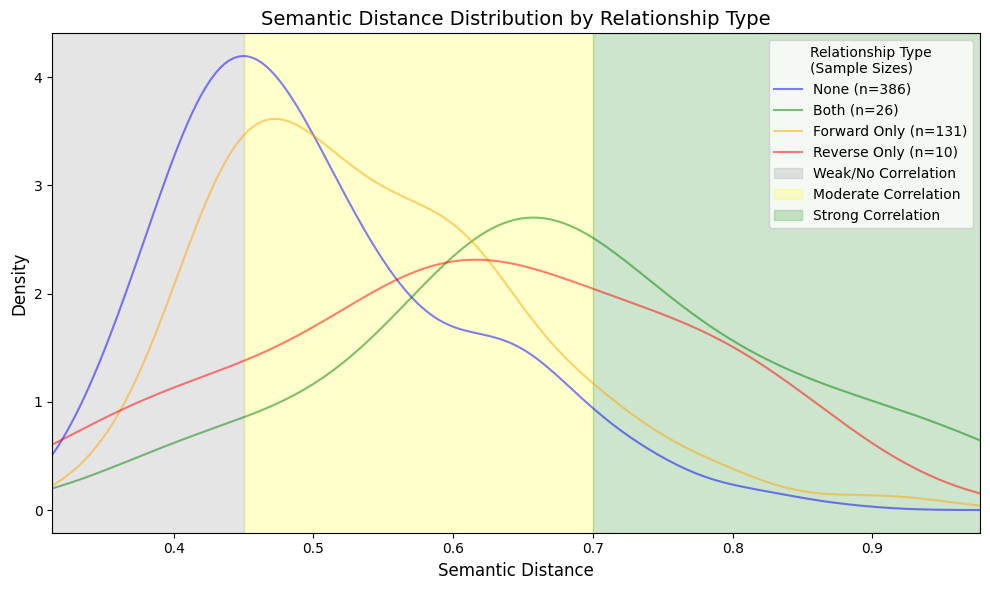

In [34]:




# Creating KDE plots for semantic distances based on relationship types
plt.figure(figsize=(10, 6))

# Get counts for each relationship type
none_count = len(analysis_df[analysis_df['relationship'] == 'none'])
both_count = len(analysis_df[analysis_df['relationship'] == 'both']) 
forward_count = len(analysis_df[analysis_df['relationship'] == 'forward_only'])
reverse_count = len(analysis_df[analysis_df['relationship'] == 'reverse_only'])

# Define the range for plotting
distance_range = np.linspace(
    analysis_df['semantic_distance'].min(),
    analysis_df['semantic_distance'].max(),
    200
)

# Plot KDE for each relationship type
for relationship, color, label in [
    ('none', 'blue', 'None'),
    ('both', 'green', 'Both'),
    ('forward_only', 'orange', 'Forward Only'),
    ('reverse_only', 'red', 'Reverse Only')
]:
    subset = analysis_df[analysis_df['relationship'] == relationship]['semantic_distance']
    if len(subset) > 0:  # Only create KDE if we have data points
        kde = stats.gaussian_kde(subset)
        plt.plot(distance_range, kde(distance_range), color=color, alpha=0.5, 
                label=f'{label} (n={len(subset)})')

# Add correlation strength regions\n",
plt.axvspan(analysis_df['semantic_distance'].min(), 0.45, alpha=0.2, color='gray', label='Weak/No Correlation')
plt.axvspan(0.45, 0.7, alpha=0.2, color='yellow', label='Moderate Correlation')
plt.axvspan(0.7, analysis_df['semantic_distance'].max(), alpha=0.2, color='green', label='Strong Correlation')
plt.xlim(analysis_df['semantic_distance'].min(),analysis_df['semantic_distance'].max())

# Adding title and labels
plt.title('Semantic Distance Distribution by Relationship Type', fontsize=14)
plt.xlabel('Semantic Distance', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Adding legend
plt.legend(title='Relationship Type\n(Sample Sizes)')

# Adjusting layout
plt.tight_layout()

# Displaying the plot
plt.show()


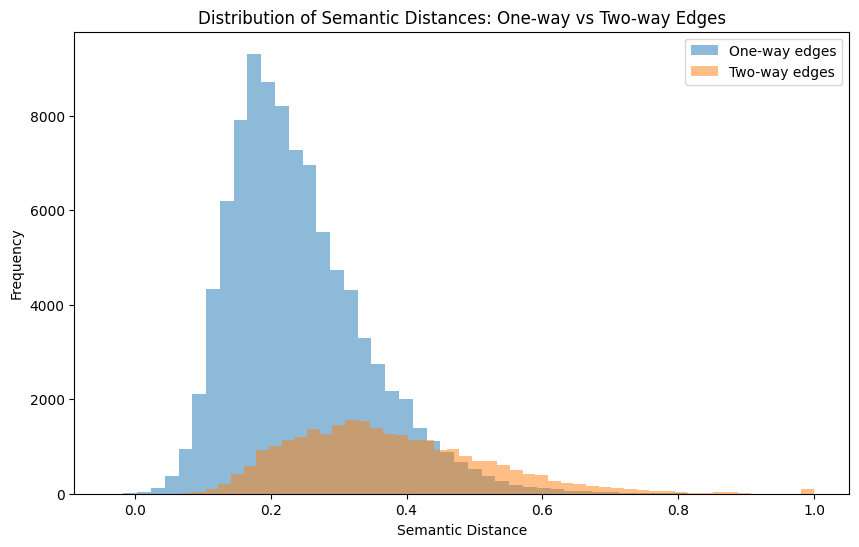

One-way edges statistics:
Mean distance: 0.240
Median distance: 0.223
Std deviation: 0.100

Two-way edges statistics:
Mean distance: 0.374
Median distance: 0.353
Std deviation: 0.144


In [35]:
import networkx as nx
article_similarities = pd.read_csv('data/article_similarities_matrix.csv')

G = nx.DiGraph()
for _, row in links.iterrows():
    G.add_edge(row['linkSource'], row['linkTarget'])

# Get one-way and two-way edges
one_way_edges = []
two_way_edges = []

for u, v in G.edges():
    # Check if the reverse edge exists
    if G.has_edge(v, u):
        # This edge pair is bidirectional
        two_way_edges.append((u, v))
    else:
        # This edge is only one-way
        one_way_edges.append((u, v))

# Calculate semantic distances for both types of edges
one_way_distances = []
two_way_distances = []

for u, v in one_way_edges:
    # Get indices for the distance matrix
    u_idx = articles[articles['article'] == u].index[0]
    v_idx = articles[articles['article'] == v].index[0]
    one_way_distances.append(article_similarities.iloc[u_idx, v_idx])


for u, v in two_way_edges:
    u_idx = articles[articles['article'] == u].index[0]
    v_idx = articles[articles['article'] == v].index[0]
    two_way_distances.append(article_similarities.iloc[u_idx, v_idx])

# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(one_way_distances, alpha=0.5, label='One-way edges', bins=50)
plt.hist(two_way_distances, alpha=0.5, label='Two-way edges', bins=50)
plt.xlabel('Semantic Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Semantic Distances: One-way vs Two-way Edges')
plt.legend()
plt.show()

# Print some statistics
print(f"One-way edges statistics:")
print(f"Mean distance: {np.mean(one_way_distances):.3f}")
print(f"Median distance: {np.median(one_way_distances):.3f}")
print(f"Std deviation: {np.std(one_way_distances):.3f}")
print("\nTwo-way edges statistics:")
print(f"Mean distance: {np.mean(two_way_distances):.3f}")
print(f"Median distance: {np.median(two_way_distances):.3f}")
print(f"Std deviation: {np.std(two_way_distances):.3f}")

In [44]:
from src.utils.visu_paths_3D import visualize_path, update_path


In [54]:
# Create the initial figure
# Create widgets for path selection
from ipywidgets import widgets

def update_path(path_type, path_number):
    if path_type == 'Unfinished Paths':
        paths_df = paths_unfinished
    else:
        paths_df = paths_finished
        
    example_path = paths_df['traversed'].iloc[path_number]
    target = paths_df['target'].iloc[path_number]
    print(f"Path: {example_path}")
    print(f"Target: {target}")
    visualize_path(example_path, reduced_embeddings3D, all_words_df, target)

path_type = widgets.RadioButtons(
    options=['Unfinished Paths', 'Finished Paths'],
    description='Path Type:',
    disabled=False
)

path_number = widgets.IntText(
    value=1021,
    description='Path ID:',
    disabled=False
)
initial_path = paths_unfinished['traversed'].iloc[1021]
initial_target = paths_unfinished['target'].iloc[1021]
fig = visualize_path(initial_path, reduced_embeddings3D, all_words_df, initial_target)
display(fig)

widgets.interactive(update_path, path_type=path_type, path_number=path_number)

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'lightgray', 'opacity': 0.3, 'size': 3},
              'mode': 'markers',
              'name': 'All articles',
              'text': array(['Áedán mac Gabráin', "One Flew Over the Cuckoo's Nest (novel)",
                             'Open cluster', ..., 'Fluorine', 'Flute', 'Zulu'], dtype=object),
              'type': 'scatter3d',
              'uid': 'cc0f43cc-0bfb-4b4a-ba7f-8cf75897b8c7',
              'x': array([-25.473059, -11.919358,  29.226793, ...,  25.047794, -14.294389,
                           11.342342], dtype=float32),
              'y': array([ 19.033033 ,  -9.4885845,   8.50076  , ..., -12.606771 , -17.919418 ,
                           15.911677 ], dtype=float32),
              'z': array([-10.286324 , -19.12454  ,  -2.665062 , ...,   4.4006977, -15.835214 ,
                            1.4663593], dtype=float32)},
             {'hoverinfo': 'text',
              'line': {'color': 'r

interactive(children=(RadioButtons(description='Path Type:', options=('Unfinished Paths', 'Finished Paths'), v…

We have officially saved Christmas, allowing Santa Claus to join the party ! 